<a href="https://colab.research.google.com/github/Dowell-Lab/psea/blob/main/notebook_examples/one_comorbid_many_gene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages we will use

In [31]:
import pandas as pd
import plotly.express as px
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.ensemble import GradientBoostingRegressor

# read in the files we will look at

In [62]:
adjpvalcol = "p_value_BenjaminiHochberg"
cuttoff = 0.1

In [37]:
url="https://raw.githubusercontent.com/Dowell-Lab/psea/refs/heads/main/testdata/psea_scores_20240923-152820.adjpval.csv"
df = pd.read_csv(url, index_col=0)
url2="https://raw.githubusercontent.com/Dowell-Lab/psea/refs/heads/main/testdata/genes.csv"
genedf = pd.read_csv(url2, index_col=0)

In [38]:
genedf["value"]=genedf["gene_id"]

In [39]:
#this brings in the medical disorders for all the individuals with Trisomy 21 in the Human Trisome Project
url = "https://raw.githubusercontent.com/Dowell-Lab/psea/refs/heads/main/testdata/comorbid_file.csv"
comorbid_df = pd.read_csv(url, index_col=0)



In [40]:
#This brings in the normalized counts for all the individuals with Trisomy 21 in the Human Trisome Project. These are not the real count data but are similar to reall count data.
#df=pd.read_csv('/content/drive/MyDrive/normcounts.csv')
url_counts="https://media.githubusercontent.com/media/Dowell-Lab/psea/refs/heads/main/testdata/value_expression_large.csv"
gene_exp_df=pd.read_csv(url_counts, index_col=0)



# Create a data frame of each gene linked to a comorbid

In [90]:
def filter_condition_gene_links_by_threshold(df, cuttoff, adjpvalcol):
  df_nona = df.dropna()
  df_nona_threshold = df_nona[df_nona[adjpvalcol]<cuttoff]
  df_nona_threshold_names = df_nona_threshold.merge(genedf, how ="inner", on="value")
  return df_nona_threshold_names


def acomorbidanditsgenes_metadata(acomorbid, genedf, cuttoff=0.1, adjpvalcol="p_value_BenjaminiHochberg"):
  df_nona_threshold_names = filter_condition_gene_links_by_threshold(df, cuttoff, adjpvalcol)
  aconditiondf = df_nona_threshold_names[df_nona_threshold_names["binary_attribute"]==acondition]
  aconditiondf = aconditiondf.sort_values(["NES"])
  return aconditiondf


def acomorbidanditsgenesexp(acomorbid, gene_exp_df, comorbid_df, df, genedf, cuttoff=0.1, adjpvalcol="p_value_BenjaminiHochberg", collect="all"):
  aconditiondf = acomorbidanditsgenes_metadata(acomorbid, genedf, cuttoff=0.1, adjpvalcol=adjpvalcol)
  if collect=="high":
    aconditiondf = aconditiondf[aconditiondf["NES"]<0]
  if collect=="low":
    aconditiondf = aconditiondf[aconditiondf["NES"]>0]
  geneensmbllist = sorted(aconditiondf["value"].to_list())
  patientgenesexpdf = gene_exp_df[geneensmbllist+["Patient"]]
  onecomborbiddf = comorbid_df[[acomorbid, "Patient"]]
  merge_df = onecomborbiddf.merge(patientgenesexpdf, on="Patient")
  return merge_df

def splitpeoplewithandwithout(acomorbid, adfofexpressionandcomorbid):
  withcomorid = adfofexpressionandcomorbid[adfofexpressionandcomorbid[acomorbid]==1].copy()
  without_comorid = adfofexpressionandcomorbid[adfofexpressionandcomorbid[acomorbid]==0].copy()
  withcomorid = withcomorid.drop(columns=["Patient", acomorbid])
  without_comorid = without_comorid.drop(columns=["Patient", acomorbid])
  return withcomorid, without_comorid

def zscoregenes(acomorbid, genexpconditiondf):
    dontuse_columns = ["Patient", acomorbid]
    gene_names = [thiscolname for thiscolname in genexpconditiondf.columns if thiscolname not in dontuse_columns]
    #df.apply(zscore)
    transpose_df = genexpconditiondf.drop(columns=dontuse_columns)
    transpose_df = transpose_df.apply(zscore)
    transpose_df["Patient"] = genexpconditiondf["Patient"]
    transpose_df[acomorbid] = genexpconditiondf[acomorbid]
    transpose_df = transpose_df[["Patient", acomorbid]+gene_names]
    return transpose_df


# Here are all the conditions with genes link

In [68]:
df_nona_threshold_names = filter_condition_gene_links_by_threshold(df, cuttoff,  adjpvalcol)
df_nona_threshold_names["binary_attribute"].unique()

array(['patent_foramen_ovale', 'obesity_disorder', 'depressive_disorder',
       'hypothyroidism', 'atrioventricular_septal_defect',
       'skeletal_system_disorder', 'otorhinolaryngologic_disease',
       'obstructive_sleep_apnea_syndrome', 'ventricular_septal_defect',
       'atopic_eczema', 'patent_ductus_arteriosus',
       'respiratory_system_disorder', 'digestive_system_disorder',
       'heart_disorder', 'gastroesophageal_reflux_disease',
       'eye_disorder', 'asthma', 'nervous_system_disorder',
       'eustachian_tube_disorder', 'psychiatric_disorder', 'tic_disorder',
       'constipation_disorder', 'hearing_loss_disorder', 'strabismus',
       'vitamin_D_deficiency', 'sleep_apnea_syndrome',
       'attention_deficit-hyperactivity_disorder', 'atrial_septal_defect',
       'folliculitis', 'skin_disorder', 'anxiety',
       'conductive_hearing_loss_disorder', 'congenital_heart_disease'],
      dtype=object)

# Look at the metadata for the genes linked to that comorbid

In [82]:
acondition = "constipation_disorder"
#acondition = "strabismus"
#acondition="eustachian_tube_disorder"
#acondition="gastroesophageal_reflux_disease"


In [70]:
gene_connected_metadata = acomorbidanditsgenes_metadata(acondition, genedf)
gene_connected_metadata

,binary_attribute,value,runpsea,NES,pval,p_value_bonf,p_value_holm,p_value_BenjaminiHochberg,p_value_BenjaminiYekutieli,seqnames,...,end,width,strand,source,type,gene_id,gene_version,gene_name,gene_source,gene_biotype
133,constipation_disorder,ENSG00000198618,included,-3.871806,0.000025,0.41439,0.411109,0.003092,0.031872,21,...,18858276,498,+,havana,gene,ENSG00000198618,5,PPIAP22,havana,processed_pseudogene
226,constipation_disorder,ENSG00000154646,included,-3.810091,0.000119,1.00000,1.000000,0.008795,0.090643,21,...,18485879,216764,-,ensembl_havana,gene,ENSG00000154646,8,TMPRSS15,ensembl_havana,protein_coding
546,constipation_disorder,ENSG00000160223,included,-3.363824,0.001487,1.00000,1.000000,0.045756,0.471571,21,...,44240966,23953,-,ensembl_havana,gene,ENSG00000160223,17,ICOSLG,ensembl_havana,protein_coding
684,constipation_disorder,ENSG00000272948,included,-3.007369,0.002721,1.00000,1.000000,0.066873,0.689205,21,...,37268497,714,+,havana,gene,ENSG00000272948,2,AP001412.1,havana,antisense
592,constipation_disorder,ENSG00000205927,included,3.121629,0.001789,1.00000,1.000000,0.050685,0.522374,21,...,33029196,3352,+,ensembl_havana,gene,ENSG00000205927,4,OLIG2,ensembl_havana,protein_coding
591,constipation_disorder,ENSG00000226043,included,3.123924,0.001788,1.00000,1.000000,0.050685,0.522374,21,...,22420819,210881,+,havana,gene,ENSG00000226043,1,AP000561.1,havana,lincRNA
471,constipation_disorder,ENSG00000197934,included,3.347971,0.001066,1.00000,1.000000,0.037814,0.389718,21,...,26569252,175618,+,havana,gene,ENSG00000197934,8,CYYR1-AS1,havana,antisense


In [71]:
protien_coding_gene_connected_metadata = gene_connected_metadata[gene_connected_metadata["gene_biotype"]=="protein_coding"]
protien_coding_gene_connected_metadata

,binary_attribute,value,runpsea,NES,pval,p_value_bonf,p_value_holm,p_value_BenjaminiHochberg,p_value_BenjaminiYekutieli,seqnames,...,end,width,strand,source,type,gene_id,gene_version,gene_name,gene_source,gene_biotype
226,constipation_disorder,ENSG00000154646,included,-3.810091,0.000119,1.0,1.0,0.008795,0.090643,21,...,18485879,216764,-,ensembl_havana,gene,ENSG00000154646,8,TMPRSS15,ensembl_havana,protein_coding
546,constipation_disorder,ENSG00000160223,included,-3.363824,0.001487,1.0,1.0,0.045756,0.471571,21,...,44240966,23953,-,ensembl_havana,gene,ENSG00000160223,17,ICOSLG,ensembl_havana,protein_coding
592,constipation_disorder,ENSG00000205927,included,3.121629,0.001789,1.0,1.0,0.050685,0.522374,21,...,33029196,3352,+,ensembl_havana,gene,ENSG00000205927,4,OLIG2,ensembl_havana,protein_coding


# Look at the patient expression for each of the genes in the data

### gene expression

In [98]:
genexpconditiondf = acomorbidanditsgenesexp(acondition,gene_exp_df, comorbid_df, df, genedf)
#genexpconditiondf = acomorbidanditsgenesexp(acondition,gene_exp_df, comorbid_df, df, genedf, collect="high") #use if you want genes up in the disorder
#genexpconditiondf = acomorbidanditsgenesexp(acondition,gene_exp_df, comorbid_df, df, genedf, collect="low") #use if you want genes down in the disorder



### Genes split on if they are up or down in the condition

In [99]:
zscore_genexpconditiondf = zscoregenes(acondition, genexpconditiondf)


In [100]:
wco, woco = splitpeoplewithandwithout(acondition, zscore_genexpconditiondf)


In [101]:
fig = px.imshow(wco)
fig.update_traces(zmax=6, zmin=-6)
fig.show()

In [102]:
fig = px.imshow(woco)
fig.update_traces(zmax=6, zmin=-6)
fig.show()

# Try to learn something with Machine learning

In [103]:
from sklearn import cluster

dontuse_columns = ["Patient", acomorbid]
gene_names = [thiscolname for thiscolname in genexpconditiondf.columns if thiscolname not in dontuse_columns]

#I should really be scaling useing scaled_df = StandardScaler().fit_transform(df)
#But that would take a while, so I'm using the zscored one...
#problem is the genes with the highest varience drive the order then

#data = genexpconditiondf.drop(columns = ["Patient", acondition])
#k_means = cluster.KMeans(n_clusters=5, max_iter=50, random_state=1)
#k_means.fit(data)
#labels = k_means.labels_
#whichcluster = pd.DataFrame(labels, index=lookatdf.Patient, columns=['Cluster_ID'])
#whichcluster.reset_index(inplace=True)
#lookatdf = lookatdf.merge(whichcluster, on="Patient")
#lookatdf = lookatdf.sort_values(["Cluster_ID"])
#lookatdf = lookatdf.drop(columns=["Cluster_ID"])
wco, woco = splitpeoplewithandwithout(acondition, genexpconditiondf)
wco.reset_index(inplace=True, drop=True)
woco.reset_index(inplace=True, drop=True)

NameError: name 'acomorbid' is not defined

In [ ]:
feature_cols = gene_names
#scale the gene expression
scaler = MinMaxScaler()
lookatdf[feature_cols] = scaler.fit_transform(lookatdf[feature_cols])
#split to gene expression and condition we are trying tp predict
X = lookatdf[feature_cols] # Features
y = lookatdf[acondition] # Target variable


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


In [ ]:
# Create Decision Tree classifer object
#clf = DecisionTreeClassifier()
clf = GradientBoostingRegressor(n_estimators=20)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

fig = px.histogram(y_pred)
fig.show()

In [ ]:
preddf = pd.DataFrame(zip(y_test,y_pred))
preddf.columns = ["truth", "prediction"]
fig = px.violin(preddf, x="truth", y="prediction", box=True, # draw box plot inside the violin
                points='all')
fig.show()

In [ ]:
y_test

,gastroesophageal_reflux_disease
120,0
102,0
142,0
154,0
62,1
...,...
218,1
63,0
26,0
16,0


In [ ]:

threshold = 0.2
binary_predictions = (y_pred > threshold).astype(int)


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, binary_predictions).ravel()
print (tn, fp, fn, tp )

41 27 3 6


In [ ]:
# Model Accuracy, how often is the classifier correct?
print("accuracy_score:",metrics.accuracy_score(y_test, y_pred))
print("average_precision_score:",metrics.average_precision_score(y_test, y_pred))
print("balanced_accuracy_score:",metrics.balanced_accuracy_score(y_test, y_pred))

precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


accuracy_score: 0.7662337662337663
average_precision_score: 0.17938311688311687
balanced_accuracy_score: 0.5557692307692308
precision: [0.86153846 0.25      ]
recall: [0.86153846 0.25      ]
fscore: [0.86153846 0.25      ]
support: [65 12]


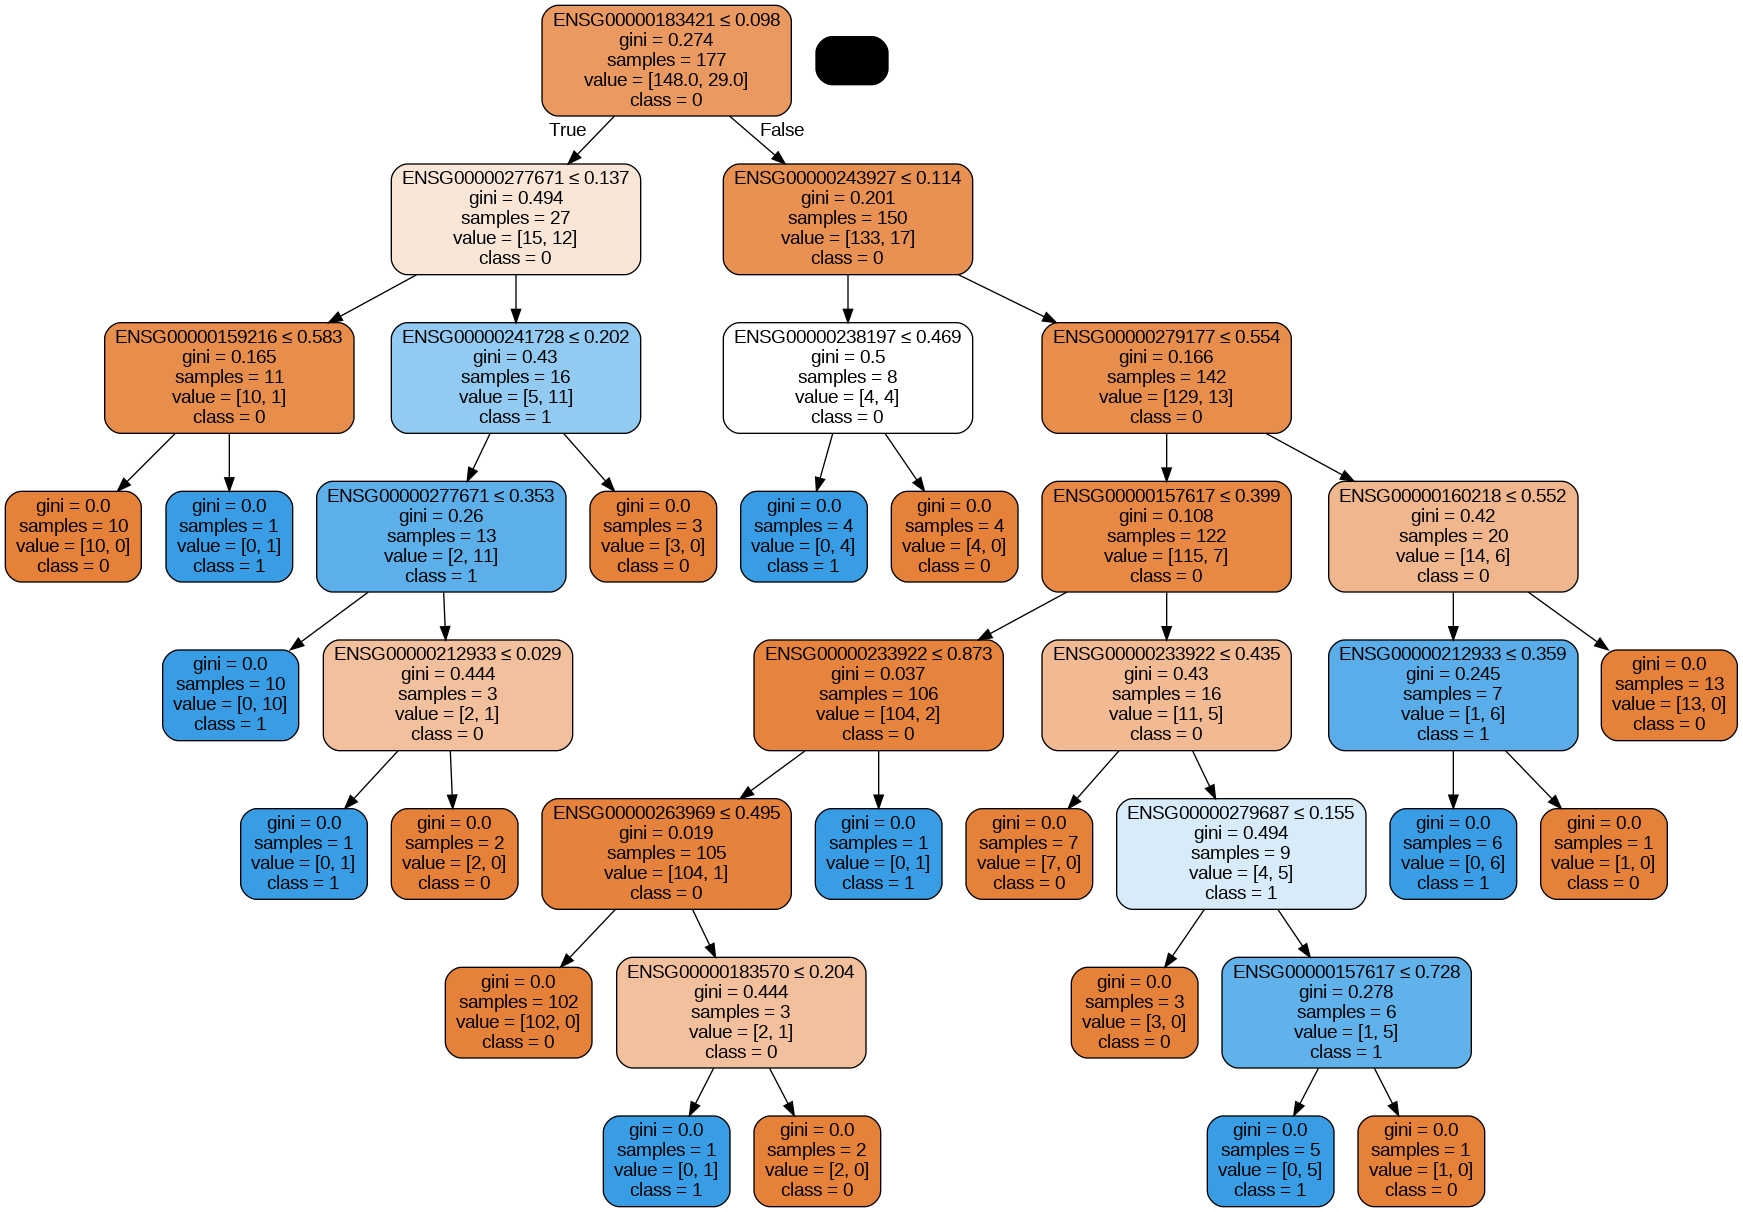

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(acondition+'_DecisionTreeClassifier.png')
Image(graph.create_png())


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn import svm

#clf = RandomForestClassifier(n_jobs=-1)
clf = svm.SVC()


#param_grid = {
#    'min_samples_split': [3, 5, 10],
#    'n_estimators' : [100, 300],
#    'max_depth': [3, 5, 15, 25],
#    'max_features': [3, 5, 10, 20, 100]}

param_grid = {
    'C': [0.1, 5, 50, 100],
    'gamma': [10, 1, 0.5, 0.1, 0.01]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'C': 50, 'gamma': 1}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg        57         8
pos         9         3
